tgb - 12/17/19 - The goal of this notebook is to code the UCnet and ACnet versions of the RH -> dRH/dt network. The constraints are linear in q_v and therefore strongly non-linear in RH. The steps are as follows:  
1) Code inversion RH->qv and dRHdt->dqvdt in numpy  
2) Convert layers in tensorflow   
3) Test network and conservation properties  
4) Train the new network for 15 epochs and save state of best validation loss

# 0) Imports

In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
import tensorflow as tf
import tensorflow.math as tfm
import tensorflow_probability as tfp
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/'
PREFIX = '8col009_01_'
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM

# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()

/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages

/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog


W0102 18:23:16.859820 22512782239552 deprecation_wrapper.py:119] From /home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/utils.py:145: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0102 18:23:16.861024 22512782239552 deprecation_wrapper.py:119] From /home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/utils.py:148: The name tf.keras.backend.set_session is deprecated. Please use tf.compat.v1.keras.backend.set_session instead.

W0102 18:23:16.863590 22512782239552 deprecation_wrapper.py:119] From /home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/utils.py:148: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


# 1) Inversion layers

Load data

In [2]:
data = xr.open_mfdataset("/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-03-01-00000.nc",\
                         decode_times=False)

/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


Convert specific humidity to relative humidity and back

Text(0.5, 0.98, 'Histogram of Specific humidity')

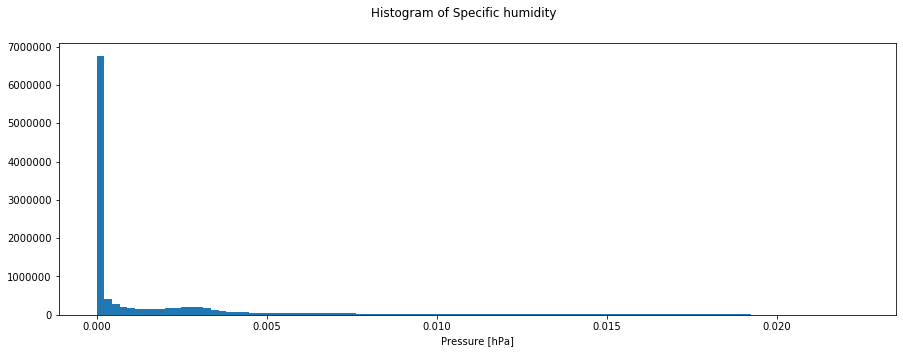

In [13]:
plt.figure(figsize=(15,5))
plt.hist(data.QAP.values.flatten(),bins=100)
plt.xlabel('Pressure [hPa]')
plt.suptitle("Histogram of Specific humidity")

Forward version

In [3]:
# SAM Constants, TODO = Check that they are the same in SPCAM
# In functions
a_liq = np.array([-0.976195544e-15,-0.952447341e-13,0.640689451e-10,0.206739458e-7,0.302950461e-5,0.264847430e-3,0.142986287e-1,0.443987641,6.11239921]);
a_ice = np.array([0.252751365e-14,0.146898966e-11,0.385852041e-9,0.602588177e-7,0.615021634e-5,0.420895665e-3,0.188439774e-1,0.503160820,6.11147274]);
c_liq = -80
c_ice = np.array([273.15,185,-100,0.00763685,0.000151069,7.48215e-07])
# General
cp = 1.004e3
g = 9.81
Lc = 2.5104e6
Lf = 0.3336e6
Ls = 2.8440e6
R = 287
Rv = 461
T0 = 273.16
T0p = 283.16
T00 = 253.16
T00p = 268.16

In [4]:
def eliq(T):
    a_liq = np.array([-0.976195544e-15,-0.952447341e-13,0.640689451e-10,0.206739458e-7,0.302950461e-5,0.264847430e-3,0.142986287e-1,0.443987641,6.11239921]);
    c_liq = -80
    T0 = 273.16
    return 100*np.polyval(a_liq,np.maximum(c_liq,T-T0))

In [5]:
def deliqdT(T):
    a_liq = np.array([-0.599634321e-17,-0.792933209e-14,-0.604119582e-12,0.385208005e-9,0.103167413e-6,0.121167162e-4,0.794747212e-3,0.285976452e-1,0.443956472])
    c_liq = -80
    T0 = 273.16
    return 100*np.polyval(a_liq,np.maximum(c_liq,T-T0))

In [6]:
def eice(T):
    a_ice = np.array([0.252751365e-14,0.146898966e-11,0.385852041e-9,0.602588177e-7,0.615021634e-5,0.420895665e-3,0.188439774e-1,0.503160820,6.11147274]);
    c_ice = np.array([273.15,185,-100,0.00763685,0.000151069,7.48215e-07])
    T0 = 273.16
    return (T>c_ice[0])*eliq(T)+\
(T<=c_ice[0])*(T>c_ice[1])*100*np.polyval(a_ice,T-T0)+\
(T<=c_ice[1])*100*(c_ice[3]+np.maximum(c_ice[2],T-T0)*(c_ice[4]+np.maximum(c_ice[2],T-T0)*c_ice[5]))    

In [7]:
def deicedT(T):
    a_ice = np.array([0.497275778e-16,0.390204672e-13,0.132073448e-10,0.255653718e-8,0.312668753e-6,0.249065913e-4,0.126710138e-2,0.377174432e-1,0.503223089])
    c_ice = np.array([273.15,185,-100,0.0013186,2.60269e-05,1.28676e-07])
    T0 = 273.16
    return (T>c_ice[0])*deliqdT(T)+\
(T<=c_ice[0])*(T>c_ice[1])*100*np.polyval(a_ice,T-T0)+\
(T<=c_ice[1])*100*(c_ice[3]+np.maximum(c_ice[2],T-T0)*(c_ice[4]+np.maximum(c_ice[2],T-T0)*c_ice[5]))    

In [8]:
def esat(T):
    T0 = 273.16
    T00 = 253.16
    omega = np.maximum(0,np.minimum(1,(T-T00)/(T0-T00)))
    
    return (T>T0)*eliq(T)+(T<T00)*eice(T)+(T<=T0)*(T>=T00)*(omega*eliq(T)+(1-omega)*eice(T))

In [9]:
def RH(T,qv,P0,PS,hyam,hybm):
    R = 287
    Rv = 461
    p = np.moveaxis((hyam*P0+hybm*PS).values,0,1) # Total pressure (Pa)
    return Rv*p*qv/(R*esat(T))

In [10]:
RH0 = RH(data.TAP.values,data.QAP,data.P0,data.PS,data.hyam,data.hybm)

In [11]:
RH0

<xarray.DataArray 'QAP' (time: 48, lev: 30, lat: 64, lon: 128)>
dask.array<shape=(48, 30, 64, 128), dtype=float64, chunksize=(48, 30, 64, 128)>
Coordinates:
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * time     (time) float64 59.0 59.02 59.04 59.06 ... 59.92 59.94 59.96 59.98

Text(0.5, 0.98, 'Histogram of Relative humidity')

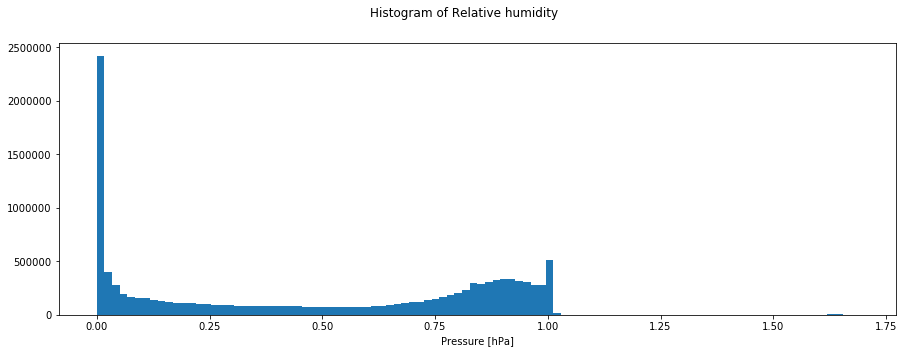

In [12]:
plt.figure(figsize=(15,5))
plt.hist(RH0.values.flatten(),bins=100)
plt.xlabel('Pressure [hPa]')
plt.suptitle("Histogram of Relative humidity")

Backward version

In [14]:
def qv(T,RH,P0,PS,hyam,hybm):
    R = 287
    Rv = 461
    p = np.moveaxis((hyam*P0+hybm*PS).values,0,1) # Total pressure (Pa)
    return R*esat(T)*RH/(Rv*p)

In [15]:
QV0 = qv(data.TAP.values,RH0,data.P0,data.PS,data.hyam,data.hybm)

Text(0.5, 0.98, 'Histogram of Specific humidity')

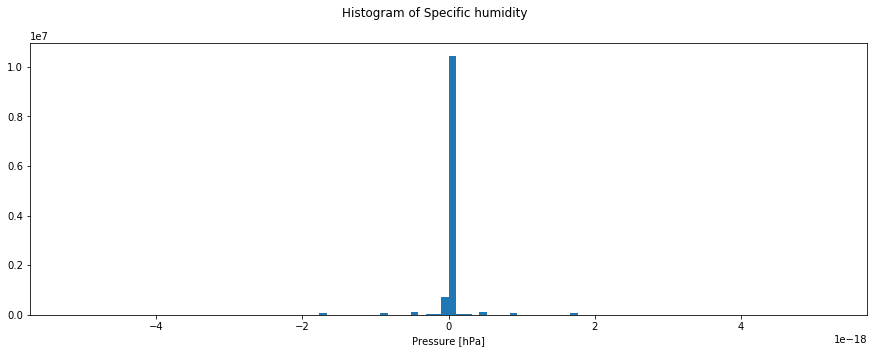

In [21]:
plt.figure(figsize=(15,5))
#plt.hist(QV0.values.flatten(),bins=100)
#plt.hist(data.QAP.values.flatten(),bins=100)
plt.hist(QV0.values.flatten()-data.QAP.values.flatten(),bins=100)
plt.xlabel('Pressure [hPa]')
plt.suptitle("Histogram of Specific humidity")

# 2) Convert to tf

This layer takes an input vector x of size 304 similar to our reference network, except that the specific humidity vector of size 30 is replaced with a relative humidity vector of size 30. The goal of this layer is to convert relative humidity back to specific humidity.